C:\Users\UOK\AppData\Local\Temp\ipykernel_14452\4275130283.py:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")


Merged shape: (1017209, 23)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,WeekOfYear,DayOfWeek_calc,IsWeekend
0,1,2,2013-01-01,0,0,0,0,a,1,c,...,2008.0,0,NaN,NaN,NaN,2013,1,1,2,0
1,1,3,2013-01-02,5530,668,1,0,0,1,c,...,2008.0,0,NaN,NaN,NaN,2013,1,1,3,0
2,1,4,2013-01-03,4327,578,1,0,0,1,c,...,2008.0,0,NaN,NaN,NaN,2013,1,1,4,0
3,1,5,2013-01-04,4486,619,1,0,0,1,c,...,2008.0,0,NaN,NaN,NaN,2013,1,1,5,0
4,1,6,2013-01-05,4997,635,1,0,0,1,c,...,2008.0,0,NaN,NaN,NaN,2013,1,1,6,1


Selected stores per group (Based on Daily Average):
Low sales [531, 461, 923]
Mid sales [1023, 393, 471]
High sales [230, 822, 526]


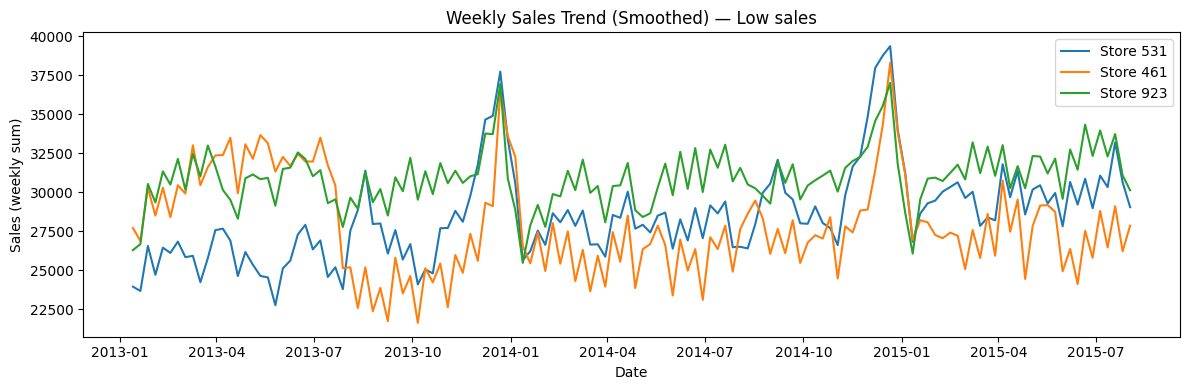

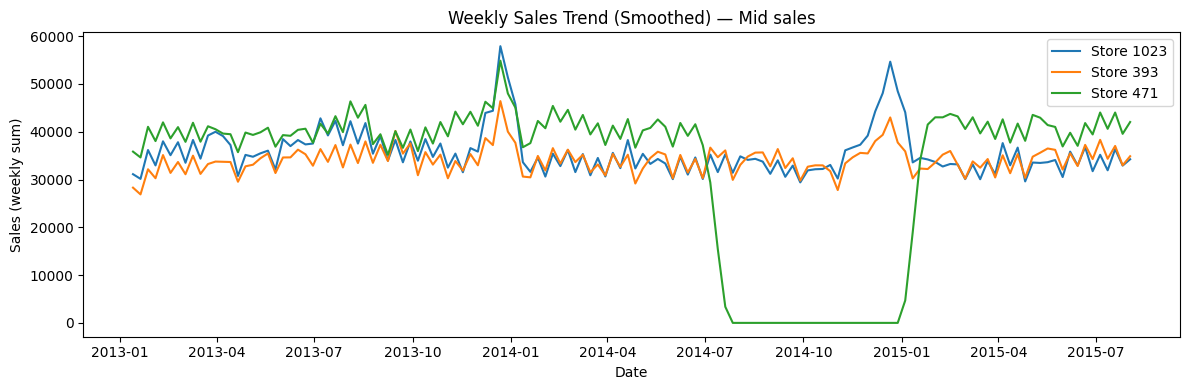

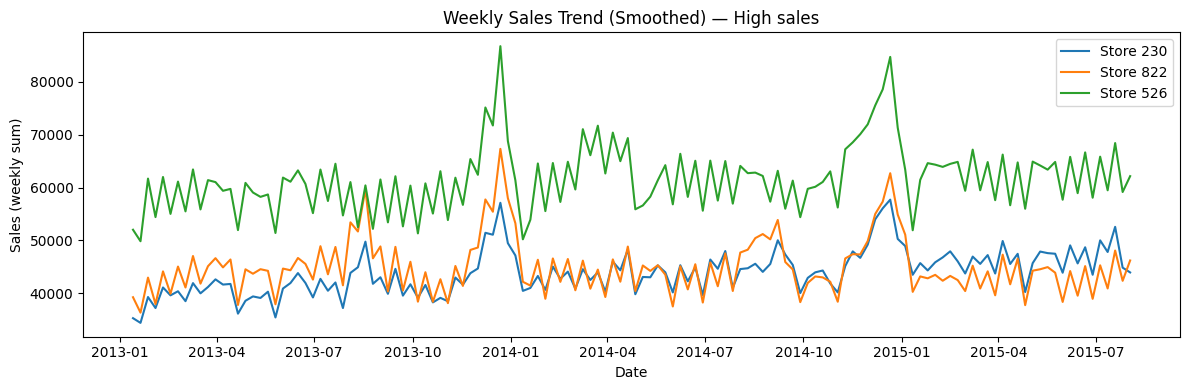

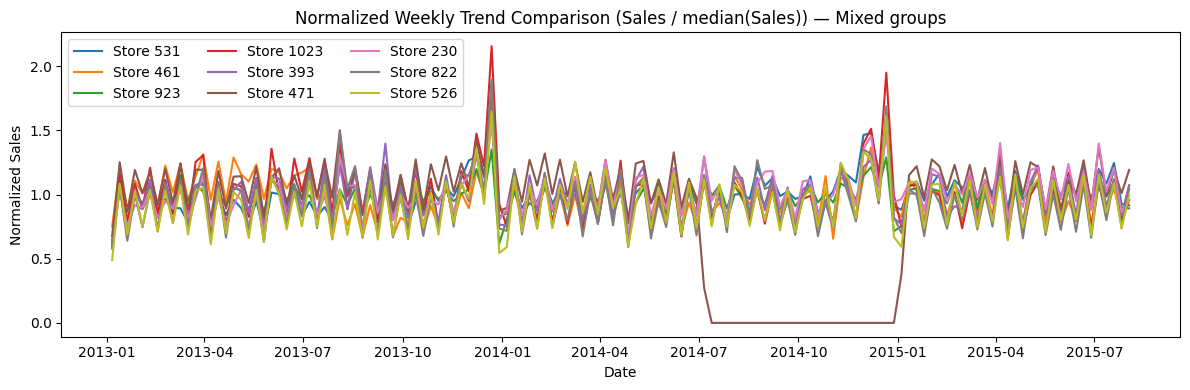

,mean,median
Promo,,
0,5929.826183,5459.0
1,8228.739731,7650.0


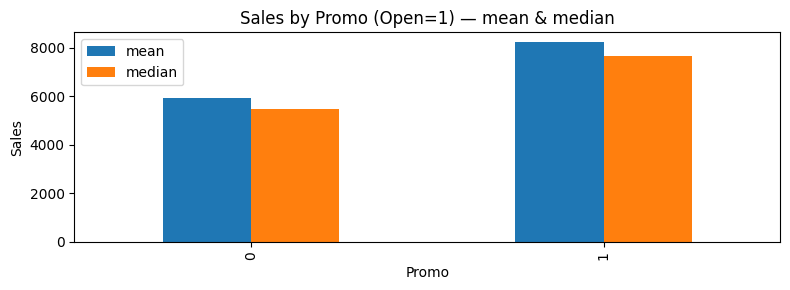

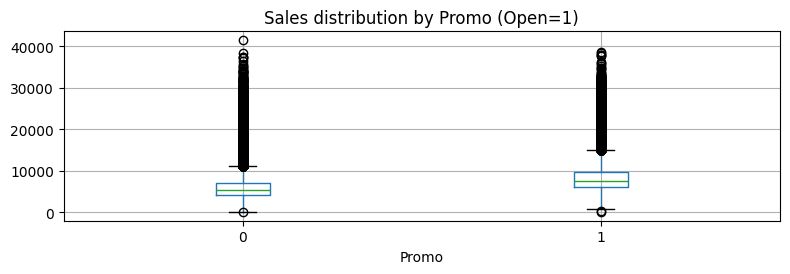

Promo uplift (relative, mean): 0.38768649816790623


,mean,median
SchoolHoliday,,
0,6897.207830,6326.0
1,7200.710282,6562.0


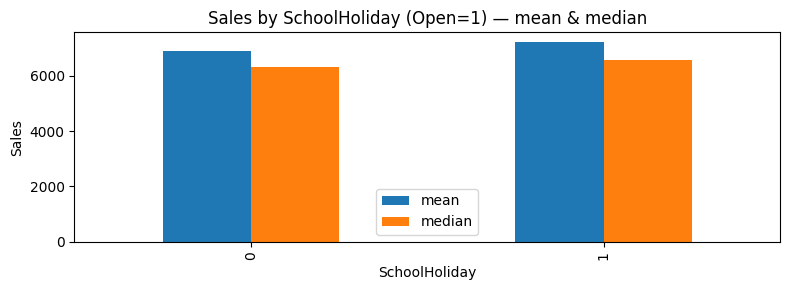

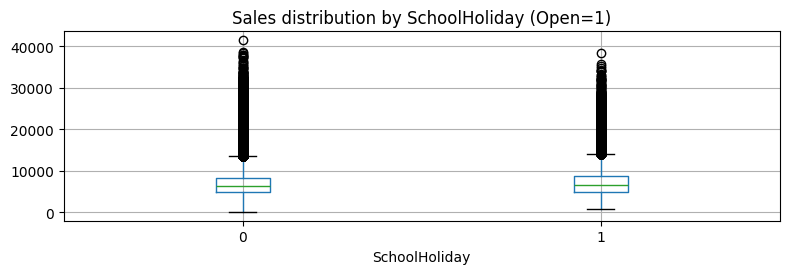

,mean,median
StateHoliday,,
0,6953.960229,6368.0
a,8487.471182,7556.0
b,9887.889655,8423.0
c,9743.746479,8397.0


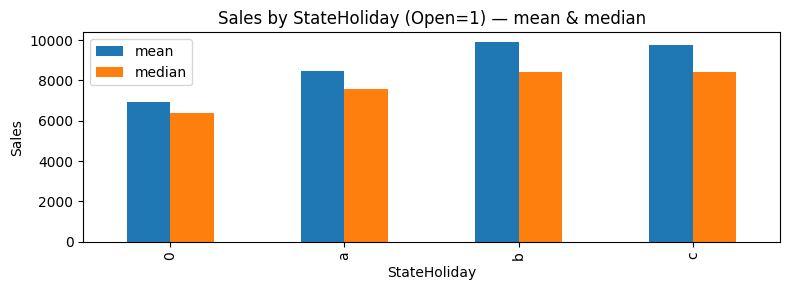

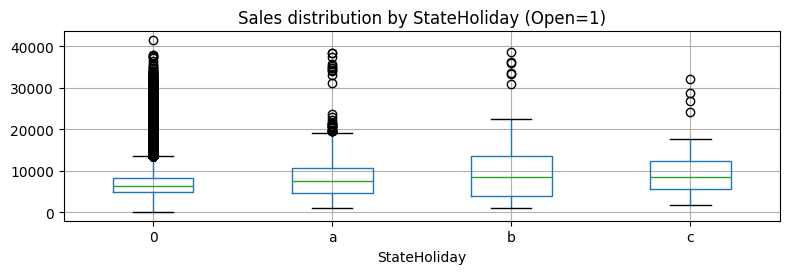

,StoreType,Promo,mean,median,count
0,a,0,5809.052116,5313.0,252532
1,a,1,8304.548971,7646.0,204510
2,b,0,9567.855955,8516.0,9622
3,b,1,11311.802796,10204.0,5938
4,c,0,6028.547554,5523.0,62235
5,c,1,8042.788106,7572.0,50733
6,d,0,5855.391063,5551.0,143074
7,d,1,8018.036562,7626.5,115694


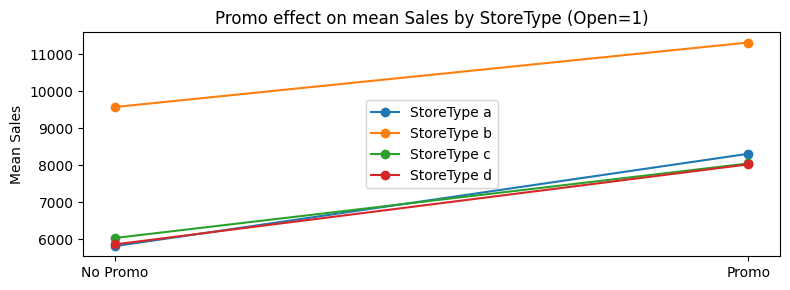

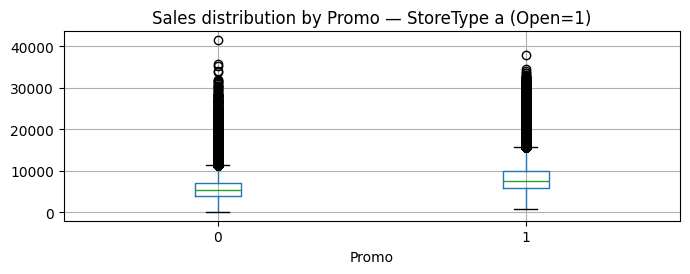

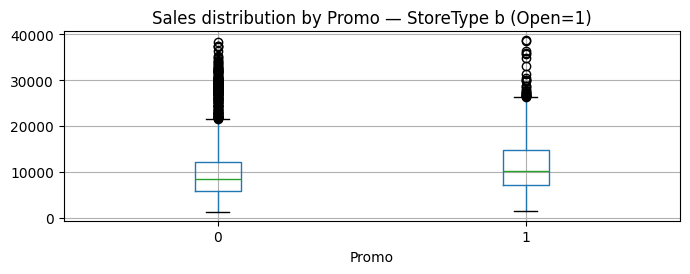

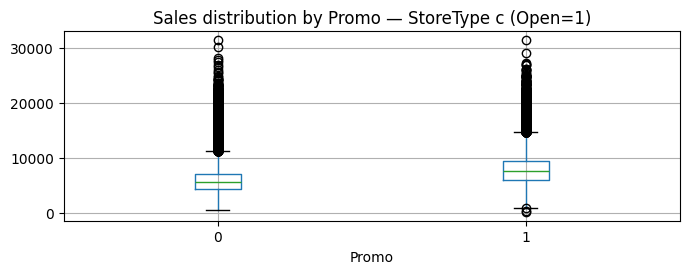

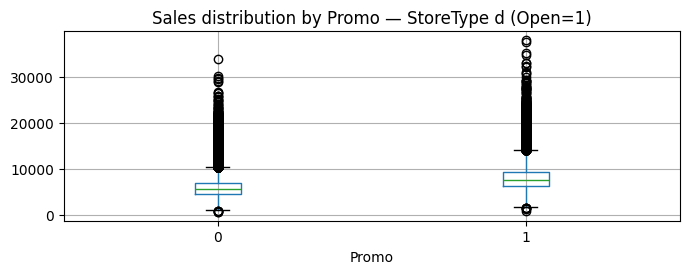

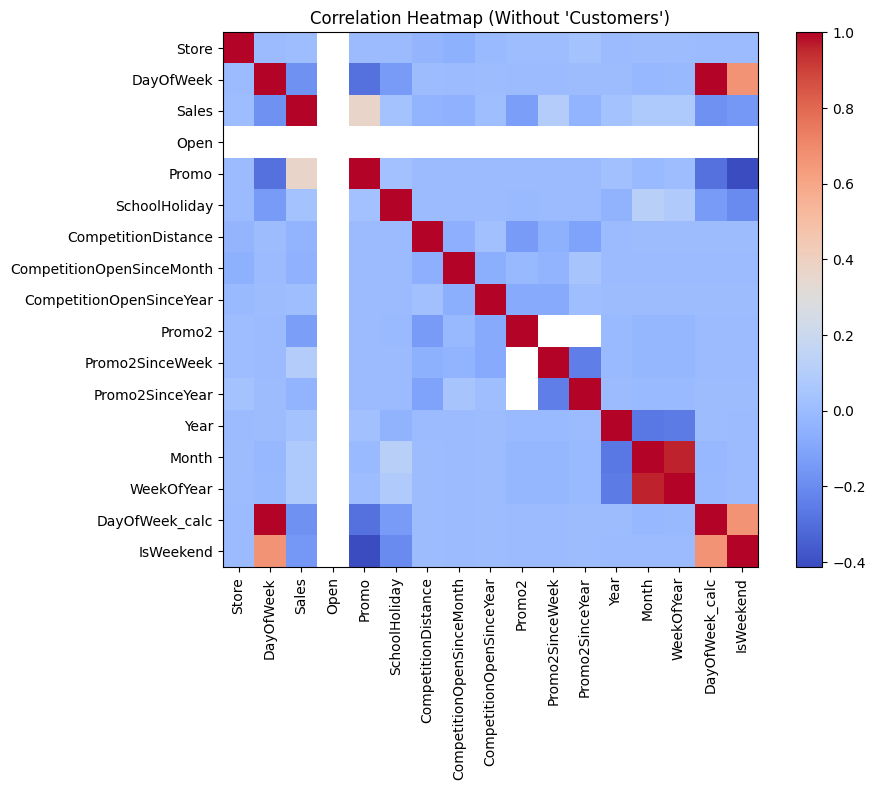

Top correlations with Sales (numeric, Open=1):


Promo                        0.368199
Promo2SinceWeek              0.095212
WeekOfYear                   0.074463
Month                        0.073589
SchoolHoliday                0.038635
Year                         0.036151
CompetitionOpenSinceYear     0.016102
Store                        0.007723
Promo2SinceYear             -0.034595
CompetitionDistance         -0.036453
CompetitionOpenSinceMonth   -0.043472
Promo2                      -0.127556
IsWeekend                   -0.151832
DayOfWeek_calc              -0.178753
DayOfWeek                   -0.178753
Name: Sales, dtype: float64

In [1]:
# =========================
# Phase 1 — Rossmann EDA & Visualization
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- 0) Load & merge ----------
train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")

train["Date"] = pd.to_datetime(train["Date"])

train = train.sort_values(by=["Store", "Date"]).reset_index(drop=True)

if "StateHoliday" in train.columns:
    train["StateHoliday"] = train["StateHoliday"].astype(str).str.replace(r"\.0$", "", regex=True)

if "Open" in train.columns:
    train["Open"] = train["Open"].fillna(1)

df = train.merge(store, on="Store", how="left")

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)
df["DayOfWeek_calc"] = df["Date"].dt.dayofweek + 1
df["IsWeekend"] = (df["DayOfWeek_calc"] >= 6).astype(int)

print("Merged shape:", df.shape)
display(df.head())

df_open = df.copy()
if "Open" in df_open.columns:
    df_open = df_open[df_open["Open"] == 1]
df_open = df_open[df_open["Sales"] > 0]


# ---------- Helpers ----------
def resample_store_sales(df_store, freq="W"):
    df_store = df_store.sort_values("Date") 
    return df_store.set_index("Date")["Sales"].resample(freq).sum().reset_index()

def pick_k(stores, k=3, seed=42):
    stores = list(stores)
    if len(stores) <= k:
        return [int(x) for x in stores]
    rng = np.random.default_rng(seed)
    return [int(x) for x in rng.choice(stores, size=k, replace=False)]

def effect_tables(dff, feature, target="Sales"):
    mean_tab = dff.groupby(feature)[target].mean()
    med_tab  = dff.groupby(feature)[target].median()
    out = pd.concat([mean_tab.rename("mean"), med_tab.rename("median")], axis=1)
    return out.sort_index()

def bar_mean_median(tab, feature):
    plt.figure(figsize=(8,3))
    tab.plot(kind="bar", ax=plt.gca()) # اصلاح باگ رسم نمودار خالی
    plt.title(f"Sales by {feature} (Open=1) — mean & median")
    plt.ylabel("Sales")
    plt.tight_layout()
    plt.show()

def boxplot_sales(dff, feature, target="Sales"):
    plt.figure(figsize=(8,3))
    dff.boxplot(column=target, by=feature, ax=plt.gca()) # اصلاح باگ رسم نمودار خالی
    plt.title(f"{target} distribution by {feature} (Open=1)")
    plt.suptitle("")
    plt.tight_layout()
    plt.show()


# =========================================================
# 1) Choose 3 store groups: low / mid / high (by average Sales)
# =========================================================
store_totals = df_open.groupby("Store")["Sales"].mean().sort_values()
q1, q2 = store_totals.quantile([0.33, 0.66]).values

low_stores = store_totals[store_totals <= q1].index
mid_stores = store_totals[(store_totals > q1) & (store_totals <= q2)].index
high_stores = store_totals[store_totals > q2].index

sel_low  = pick_k(low_stores,  k=3, seed=1)
sel_mid  = pick_k(mid_stores,  k=3, seed=2)
sel_high = pick_k(high_stores, k=3, seed=3)

selected_groups = {
    "Low sales": sel_low,
    "Mid sales": sel_mid,
    "High sales": sel_high,
}

print("Selected stores per group (Based on Daily Average):")
for g, s in selected_groups.items():
    print(g, s)

# =========================================================
# 2) Trend plots — groups (weekly smoothed)
# =========================================================
for group_name, stores_ in selected_groups.items():
    plt.figure(figsize=(12,4))
    for s in stores_:
        ds = df[df["Store"] == s][["Date","Sales"]].copy()
        ds = resample_store_sales(ds, freq="W")
        y = ds["Sales"].rolling(3, min_periods=2).mean()
        plt.plot(ds["Date"], y, label=f"Store {s}")
    plt.title(f"Weekly Sales Trend (Smoothed) — {group_name}")
    plt.xlabel("Date")
    plt.ylabel("Sales (weekly sum)")
    plt.legend()
    plt.tight_layout()
    plt.show()

all_selected = sel_low + sel_mid + sel_high
plt.figure(figsize=(12,4))
for s in all_selected:
    ds = df[df["Store"] == s][["Date","Sales"]].copy()
    ds = resample_store_sales(ds, freq="W")
    y = ds["Sales"].astype(float)
    denom = np.median(y) if np.median(y) != 0 else 1.0
    plt.plot(ds["Date"], y/denom, label=f"Store {s}")
plt.title("Normalized Weekly Trend Comparison (Sales / median(Sales)) — Mixed groups")
plt.xlabel("Date")
plt.ylabel("Normalized Sales")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()

# =========================================================
# 3) Feature impact — mean + median + boxplot
# =========================================================
promo_tab = effect_tables(df_open, "Promo")
display(promo_tab)
bar_mean_median(promo_tab, "Promo")
boxplot_sales(df_open, "Promo")

if 0 in promo_tab.index and 1 in promo_tab.index:
    uplift = (promo_tab.loc[1, "mean"] - promo_tab.loc[0, "mean"]) / (promo_tab.loc[0, "mean"] + 1e-12)
    print("Promo uplift (relative, mean):", float(uplift))

school_tab = effect_tables(df_open, "SchoolHoliday")
display(school_tab)
bar_mean_median(school_tab, "SchoolHoliday")
boxplot_sales(df_open, "SchoolHoliday")

if "StateHoliday" in df_open.columns:
    state_tab = effect_tables(df_open, "StateHoliday")
    display(state_tab)
    bar_mean_median(state_tab, "StateHoliday")
    boxplot_sales(df_open, "StateHoliday")

# =========================================================
# 4) Promo effect per StoreType (mean + median + boxplot)
# =========================================================
if "StoreType" in df_open.columns:
    promo_by_type = (
        df_open.groupby(["StoreType", "Promo"])["Sales"]
        .agg(["mean", "median", "count"])
        .reset_index()
        .sort_values(["StoreType","Promo"])
    )
    display(promo_by_type)

    # Line plot of mean Sales by Promo within each StoreType
    plt.figure(figsize=(8,3))
    for st in sorted(df_open["StoreType"].dropna().unique()):
        tmp = promo_by_type[promo_by_type["StoreType"] == st].set_index("Promo")
        if 0 in tmp.index and 1 in tmp.index:
            plt.plot([0,1], [tmp.loc[0,"mean"], tmp.loc[1,"mean"]], marker="o", label=f"StoreType {st}")
    plt.xticks([0,1], ["No Promo","Promo"])
    plt.title("Promo effect on mean Sales by StoreType (Open=1)")
    plt.ylabel("Mean Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Boxplots per StoreType
    for st in sorted(df_open["StoreType"].dropna().unique()):
        d = df_open[df_open["StoreType"] == st]
        plt.figure(figsize=(7,3))
        d.boxplot(column="Sales", by="Promo", ax=plt.gca())
        plt.title(f"Sales distribution by Promo — StoreType {st} (Open=1)")
        plt.suptitle("")
        plt.tight_layout()
        plt.show()
else:
    print("StoreType not found (unexpected after merge).")

# =========================================================
# 5) Correlation heatmap + Top correlations with Sales
# =========================================================
num = df_open.select_dtypes(include=["number"]).drop(columns=["Customers"], errors="ignore").copy()
corr = num.corr(numeric_only=True)

plt.figure(figsize=(10,8))
plt.imshow(corr.values, cmap="coolwarm")
plt.title("Correlation Heatmap (Without 'Customers')")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.tight_layout()
plt.show()

if "Sales" in corr.columns:
    sales_corr = corr["Sales"].drop("Sales", errors="ignore").sort_values(ascending=False)
    print("Top correlations with Sales (numeric, Open=1):")
    display(sales_corr.head(15))